# Here i will show how you can use Plumed built in CV module to implement the a PyTorch neural network and run it on image data

This will NOT optimize the network, rather just do a forward pass through the computational graph.

[Plumed](plumed.github.io) is a powerful library used for running enhanced sampling simulations. It implements an very robust Collective variable module. Here I will show that you can implement a 3-layered neural network inside Plumed using its built in functions. This is possible because simpler networks are a series of linear/affine transforms 
$$y= W^Tx +b$$
plus non-linear layers(sigmoid here) 
$$\sigma(x) = \frac{1}{1+e^{-x}} $$

Both of these operations can be evaluated using the matheval library inside Plumed (skip to the end if you want the actual code)

# First an introduction to our sysetem: Tiny ImageNet

Tiny image net has a large number of small 64*64 pixel sized images. I randomly pulled 50 images for testing 

In [43]:
from msmbuilder.example_datasets import AlanineDipeptide
from msmbuilder.featurizer import DihedralFeaturizer
%pylab inline
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
sns.set(style='whitegrid', palette='colorblind')
sns.set_context('talk',1.3)
import numpy as np
import sys,os,glob
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable


sys.path.insert(0, "helper_func")
%load_ext autoreload
%autoreload 2


import torch as t
from torchvision.transforms import ToPILImage
from IPython.display import Image
to_img = ToPILImage()

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Here are a few random examples. 

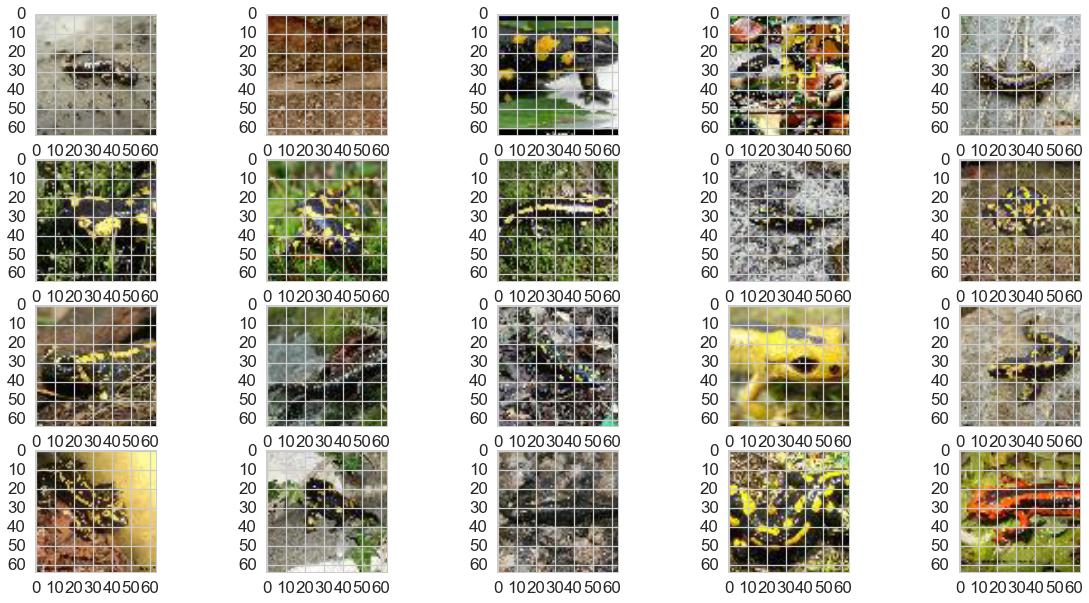

In [37]:
import matplotlib.image as mpimg
plt.figure(figsize=(20,10))
images = []
for img_path in glob.glob('data/image_data/*.jpeg'):
    images.append(mpimg.imread(img_path))
    
for i in range(20):
    plt.subplot(4,5,i+1)
    plt.imshow(images[i])
    #sns.despine()

In [38]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
data = ImageFolder(root='data', transform=ToTensor())


In [40]:
from torch.utils.data import DataLoader
loader = DataLoader(data)
for x, y in loader:
    print(x) # image
    print(y) # image label
    break


(0 ,0 ,.,.) = 
  0.7725  0.7647  0.7725  ...   0.4314  0.4118  0.1922
  0.8275  0.8431  0.8392  ...   0.4902  0.5843  0.4078
  0.8000  0.8314  0.8196  ...   0.5333  0.7725  0.7647
           ...             ⋱             ...          
  0.3725  0.2784  0.3451  ...   0.2118  0.1490  0.1294
  0.4980  0.4196  0.4667  ...   0.1412  0.1451  0.1333
  0.4078  0.4235  0.5176  ...   0.1608  0.1725  0.1176

(0 ,1 ,.,.) = 
  0.7765  0.7686  0.7765  ...   0.4275  0.4118  0.1922
  0.8314  0.8471  0.8431  ...   0.4863  0.5843  0.4078
  0.8039  0.8353  0.8235  ...   0.5294  0.7725  0.7647
           ...             ⋱             ...          
  0.3725  0.2784  0.3451  ...   0.1843  0.1216  0.1020
  0.4980  0.4196  0.4667  ...   0.1137  0.1176  0.1059
  0.4078  0.4235  0.5176  ...   0.1333  0.1451  0.0902

(0 ,2 ,.,.) = 
  0.7569  0.7451  0.7529  ...   0.3451  0.3176  0.0980
  0.8078  0.8235  0.8196  ...   0.4039  0.4902  0.3137
  0.7804  0.8118  0.8000  ...   0.4471  0.6784  0.6706
           ...   

# Defining our network in PyTorch is very easy 

In [327]:
# We have a VERY basic 3 layerd network with an affine layer, a sigmoid non-linearity, and a final  Affine layer
# Image --> Affine --> Sigmoid --> Affine --> Score

In [57]:

# Hyper Parameters 
input_size = 3*64*64
hidden_size = 10
num_classes = 5

class Net(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(Net, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.l1 = nn.Linear(input_size, hidden_size) 
        self.l2 = nn.Sigmoid()
        self.l3 = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        out = self.l1(x)
        out = self.l2(out)
        out = self.l3(out)
        return out
    
net = Net(input_size, hidden_size, num_classes)


# We can write code to convert an Image into an atomic simulation trajectory such that each frame is a separate image and each pixel is an atom with the RGB values becoming the xyz coordinates

 This is necessary because the Plumed only accepts trajectory inputs and not images

In [193]:
fake_top_list=[]
for i in range(64*64):
    fake_top_list.append({'serial':i,'name':"H1", "element":"H","resSeq":i,"resName":"H","chainID":"A"})
t2 = md.Topology.from_dataframe(pd.DataFrame(fake_top_list), None)

In [218]:
index = 0
loader = DataLoader(data)
for x, y in loader:
    xyz = np.array(x.view(-1,3*64*64).tolist()[0]).reshape(64*64,3)
    pred_y = net(Variable(x.view(-1,3*64*64)))
    if index == 0:
        all_pred = pred_y
        t1 = md.Trajectory(xyz=xyz, topology=t2)
    else:
        all_pred = torch.cat((all_pred,pred_y,))
        t1 += md.Trajectory(xyz=xyz, topology=t2)
    assert np.allclose(x.view(-1,3*64*64).tolist()[0],t1.xyz[-1].reshape(3*64*64))
    index += 1

In [220]:
t1.save_xtc("./images.xtc")

# lets make sure we can recover the image

In [306]:
from torchvision.utils import make_grid

(0, 63)

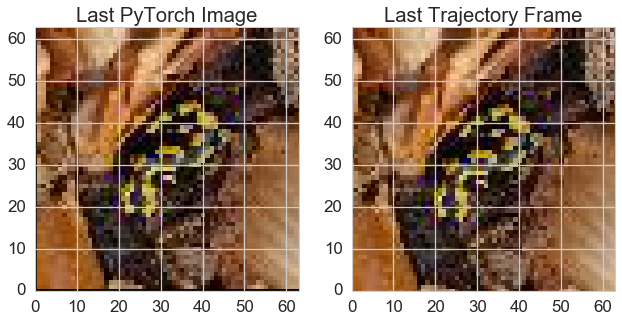

In [324]:
subplot(1,2,1)
title("Last PyTorch Image")
imshow(np.transpose(make_grid(x,padding=0).numpy(),(1,2,0)),interpolation='Nearest')
xlim([0,63])
ylim([0,63])
subplot(1,2,2)
title("Last Trajectory Frame")
imshow(np.transpose(t1.xyz[-1].reshape((3,64,64)),(1,2,0)),interpolation='Nearest')
xlim([0,63])
ylim([0,63])

In [221]:
nn_y = np.array(all_pred.data.tolist())

In [490]:
# Save network before something happens

In [335]:
torch.save(net,"imagenetwork.net")

/Users/muneeb/Documents/anaconda/lib/python3.5/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


# Now we write the 3 layered network into Plumed using a series of vector operations + exponential transforms

First the results!

In [332]:
output =  render_network(net)
with open("image_plumed.dat",'w') as f:
    f.writelines(output)

The full output file is 4136 lines so we wont show all of it but here are the first and last few lines

In [334]:
!head image_plumed.dat

POSITION ATOM=1 LABEL=l00
POSITION ATOM=2 LABEL=l01
POSITION ATOM=3 LABEL=l02
POSITION ATOM=4 LABEL=l03
POSITION ATOM=5 LABEL=l04
POSITION ATOM=6 LABEL=l05
POSITION ATOM=7 LABEL=l06
POSITION ATOM=8 LABEL=l07
POSITION ATOM=9 LABEL=l08
POSITION ATOM=10 LABEL=l09


In [333]:
!tail image_plumed.dat

MATHEVAL ARG=l30nb FUNC=x+-0.23702505230903625 LABEL=l30 PERIODIC=NO 
COMBINE LABEL=l31nb ARG=l20,l21,l22,l23,l24,l25,l26,l27,l28,l29 COEFFICIENTS=-0.033247459679841995,-0.09533906728029251,0.2839641869068146,0.14302553236484528,-0.016756366938352585,0.0030033804941922426,-0.007324981037527323,-0.13150586187839508,-0.17639784514904022,0.2092045396566391 PERIODIC=NO 
MATHEVAL ARG=l31nb FUNC=x+0.15838494896888733 LABEL=l31 PERIODIC=NO 
COMBINE LABEL=l32nb ARG=l20,l21,l22,l23,l24,l25,l26,l27,l28,l29 COEFFICIENTS=0.126211017370224,-0.08337747305631638,0.12218132615089417,0.004285994451493025,0.24739477038383484,0.05724741891026497,0.09746275097131729,-0.022697072476148605,0.2092171311378479,-0.18604600429534912 PERIODIC=NO 
MATHEVAL ARG=l32nb FUNC=x+-0.11606910079717636 LABEL=l32 PERIODIC=NO 
COMBINE LABEL=l33nb ARG=l20,l21,l22,l23,l24,l25,l26,l27,l28,l29 COEFFICIENTS=-0.28736475110054016,-0.1792229861021042,0.21712186932563782,-0.29023414850234985,-0.19442622363567352,0.24557547271251678,

# This is all possible because the all the layers in the network can be programmatically generated to depend on the output of the previous layer/s

In [251]:
# this creates the feature extractor 
def write_xyz_feature(t1):
    output = []
    for i in range(t1.n_atoms):
        output.append(plumed_position_templete.render(arg=i+1,label="l0%d"%(i)))
        output.append("\n")
    return ''.join(output)

# this creates a fully connected layer
def render_fc_layer(layer_indx, lp):
    output=[]
    for i in np.arange(lp.out_features):
        if layer_indx == 1:
            # we need the x,y,z(RGB) for each atom(pixel)
            arg = ','.join(["l0%d.%s"%(i,j) for i in range(4096) for j in ["x","y","z"]])
        else:
            # otherwise use the previous layer
            arg=','.join(["l%d%d"%(layer_indx-1,j) for j in range(lp.in_features)])
        
        weights = ','.join(map(str,lp.weight[i].data.tolist()))
        bias =','.join(map(str,lp.bias[i].data.tolist()))
        
        # combine without bias
        non_bias_label = "l%d%dnb"%(layer_indx, i)
        output.append(plumed_combine_template.render(arg = arg,
                                   coefficients = weights,
                                   label=non_bias_label,
                                   periodic="NO") +"\n")
        # now add the bias
        bias_label = "l%d%d"%(layer_indx, i)
        output.append(create_neural_bias(non_bias_label, bias, bias_label))
        output.append("\n")
    return ''.join(output)
    
    
# this cretes a sigmoid layer
def render_sigmoid_layer(layer_indx, lp, hidden_size=50):
    output=[]    
    for i in np.arange(hidden_size):
        arg="l%d%d"%(layer_indx-1, i)
        label = "l%d%d"%(layer_indx, i)
        output.append(create_sigmoid(arg, label))
        output.append("\n")
        
    return ''.join(output)

# All we need to then is decide what type of layer we are on, and call the appropriate function

In [328]:
def render_network(net):
    output =[]
    # Start by evaluating the actual dihedrals + sin-cosine transform aka the input features 
    output.append(write_xyz_feature(t1))
    index = 0
    # Go over every layer of the netowrk
    for lp in net.children():
        index += 1
        if str(lp).startswith("Linear"):
            output.append(render_fc_layer(index, lp))
        elif str(lp).startswith("Sigmoid"):
            output.append(render_sigmoid_layer(index, lp,hidden_size=net.hidden_size))
        else:
            raise ValueError("Only Linear and Sigmoid Layers are supported for now")
    # Lastly, we want to print out the values from the last layer. This becomes our CV. 
    arg = ','.join(["l%d%d"%(index,j) for j in range(num_classes)])
    output.append(render_print_val(arg, file="ImageCV"))
    return ''.join(output)

# We can now run Plumed locally or on a compute cluster and then compare its output to our PyTorch implementation

In [336]:
#This command will generate the output for us
# plumed driver --mf_xtc images.xtc --plumed image_plumed.dat

In [337]:
# the 0th column in plumeds' CV file is always time so all outputs are off by 1
plumed_vals = np.loadtxt("ImageCV")

Lets do a scatter plot to make sure that they are equal. 

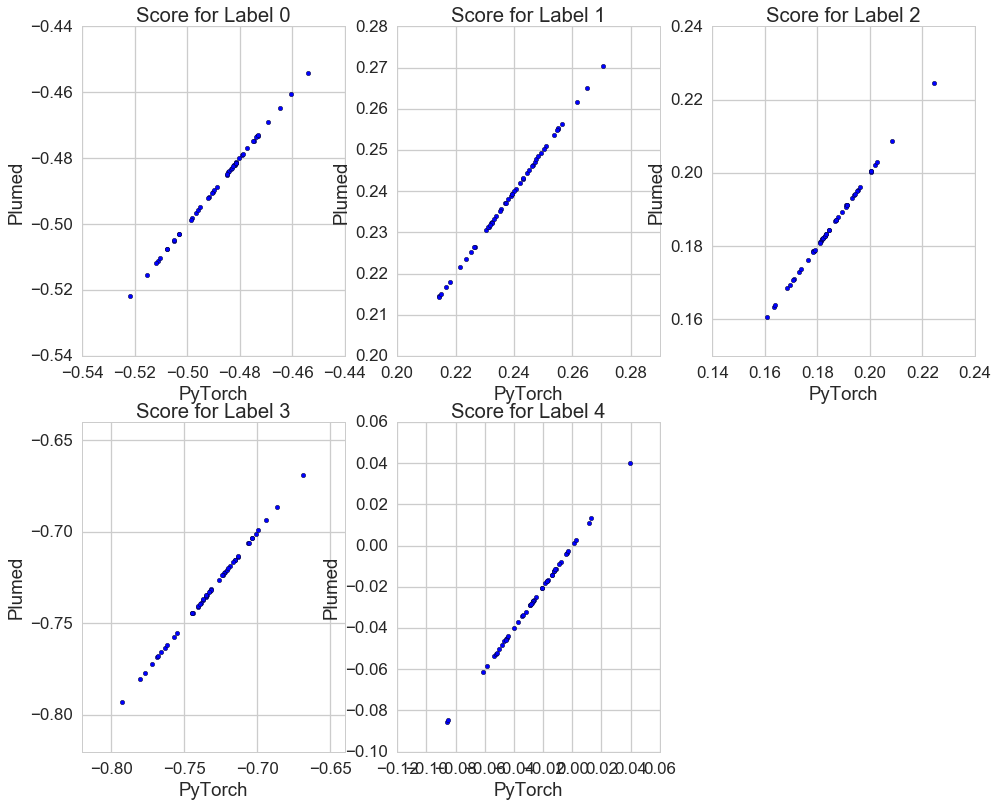

In [352]:
plt.figure(figsize=(16,13))
for i in range(5):
    plt.subplot(2,3,i+1)
    plt.title("Score for Label %d"%i)
    plt.scatter(nn_y[:,i],plumed_vals[:,i+1])
    assert np.allclose(nn_y[:,i],plumed_vals[:,i+1],1e-4,1e-4)
    plt.xlabel("PyTorch")
    plt.ylabel("Plumed")

# Plumed cant do this very well

Ultimately, this is a very convoluted way to convert images to class scores, and was done mostly as a proof of concept. Plumed was able to handle the network mathematics, but it had a very long startup time which I suspect had something how it sequentially reads the files,making it slow.

# Other helper functions 

In [173]:
from jinja2 import Template

In [174]:
plumed_torsion_template = Template("TORSION ATOMS={{atoms}} LABEL={{label}} ")

plumed_matheval_template = Template("MATHEVAL ARG={{arg}} FUNC={{func}} LABEL={{label}} PERIODIC={{periodic}} ")

plumed_combine_template = Template("COMBINE LABEL={{label}} ARG={{arg}} COEFFICIENTS={{coefficients}} "+\
                                    "PERIODIC={{periodic}} ")
plumed_print_template = Template("PRINT ARG={{arg}} STRIDE={{stride}} FILE={{file}} ")

#p: POSITION ATOM=3
plumed_position_templete = Template("POSITION ATOM={{arg}} LABEL={{label}}")

In [175]:
def create_torsion_label(inds, label):
    #t: TORSION ATOMS=inds
    return plumed_torsion_template.render(atoms=','.join(map(str, inds)), label=label) +"\n"


def create_feature(argument, func, feature_label):
    arg = argument
    x="x"
    if func in ["sin","cos"]:
        f = "%s(%s)"%(func,x)
        label = feature_label
    else:
        raise ValueError("Can't find function")

    return plumed_matheval_template.render(arg=arg, func=f,\
                                           label=label,periodic="NO")


def create_neural_bias(nb, bias, label):
    arg = ",".join([nb])
    f = "+".join(["x", bias])
    return plumed_matheval_template.render(arg=arg, func=f,\
                                           label=label,periodic="NO")
def create_sigmoid(arg, label):
    f = "1/(1+exp(-x))"
    return plumed_matheval_template.render(arg=arg, func=f,\
                                           label=label,periodic="NO")

def render_print_val(arg,stride=1,file="CV"):
    return plumed_print_template.render(arg=arg,
                                       stride=stride,
                                       file=file)


In [176]:
def get_feature_function(df, feature_index):
    possibles = globals().copy()
    possibles.update(locals())
    func = possibles.get("create_torsion_label")
    return func

In [177]:
def match_mean_free_function(df, feature_index):
    func = df.otherinfo[feature_index]
    return func